In [1]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import os  # Importing the OS module to interact with the operating system
import time  # Importing the Time module to handle time-related tasks
import shutil  # Importing the Shutil module for high-level file operations
import pathlib  # Importing the Pathlib module for object-oriented filesystem paths
import itertools  # Importing the Itertools module for creating iterators
from PIL import Image  # Importing the Image module from PIL (Pillow) for image processing

import cv2  # Importing the OpenCV library for computer vision tasks
import numpy as np  # Importing the Numpy library for numerical operations

import pandas as pd  # Importing the Pandas library for data manipulation
import seaborn as sns  # Importing the Seaborn library for statistical data visualization
sns.set_style('darkgrid')  # Setting the style for Seaborn plots
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting
from sklearn.model_selection import train_test_split  # Importing train_test_split for splitting data into training and testing sets
from sklearn.metrics import confusion_matrix, classification_report  # Importing metrics for evaluating model performance

import torch  # Importing the PyTorch library for deep learning
import torch.nn as nn  # Importing the neural network module from PyTorch
import torch.optim as optim  # Importing the optimization module from PyTorch
from torch.utils.data import DataLoader, Dataset  # Importing DataLoader and Dataset classes for data handling
from torchvision import transforms, models  # Importing transforms and models from torchvision
from torchvision.datasets import ImageFolder  # Importing ImageFolder for loading datasets from directories

import warnings  # Importing the warnings module to manage warnings
warnings.filterwarnings("ignore")  # Ignoring all warnings

print('modules loaded')  # Printing a confirmation that modules are loaded

modules loaded


In [5]:
model_dir = os.environ['FINN_ROOT'] + "/notebooks/FINN_Brevitas"
data_path = model_dir + "/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

images = []  # Initializing an empty list to store image paths
labels = []  # Initializing an empty list to store labels

for subfolder in os.listdir(data_path):  # Iterating through each subfolder in the dataset path
    subfolder_path = os.path.join(data_path, subfolder)  # Constructing the path to the subfolder
    if not os.path.isdir(subfolder_path):  # Checking if the path is a directory
        continue  # Skipping if it's not a directory

    for image_filename in os.listdir(subfolder_path):  # Iterating through each file in the subfolder
        image_path = os.path.join(subfolder_path, image_filename)  # Constructing the path to the image
        images.append(image_path)  # Appending the image path to the images list
        labels.append(subfolder)  # Appending the subfolder name (label) to the labels list

data = pd.DataFrame({'image': images, 'label': labels})  # Creating a DataFrame from the images and labels lists
data.head()  # Displaying the first few rows of the DataFrame
data.shape  # Displaying the shape of the DataFrame
strat = data['label']  # Extracting the labels column for stratification
train_df, dummy_df = train_test_split(data, train_size=0.80, shuffle=True, random_state=123, stratify=strat)  # Splitting the data into training and a temporary set

strat = dummy_df['label']  # Extracting labels from the temporary set for stratification
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)  # Splitting the temporary set into validation and test sets
print("Training set shape:", train_df.shape)  # Printing the shape of the training set
print("Validation set shape:", valid_df.shape)  # Printing the shape of the validation set
print("Test set shape:", test_df.shape)  # Printing the shape of the test set
batch_size = 16  # Setting the batch size for data loaders
img_size = (224, 224)  # Setting the image size
channels = 3  # Setting the number of color channels
img_shape = (img_size[0], img_size[1], channels)  # Defining the shape of the image

# Define custom Dataset class
class CustomDataset(Dataset):  # Defining a custom dataset class
    def __init__(self, dataframe, transform=None, class_indices=None):  # Initializing the dataset
        self.dataframe = dataframe  # Storing the dataframe
        self.transform = transform  # Storing the transformations
        self.class_indices = class_indices  # Storing class indices

    def __len__(self):  # Defining the length method
        return len(self.dataframe)  # Returning the length of the dataframe

    def __getitem__(self, idx):  # Defining the get item method
        img_path = self.dataframe.iloc[idx]['image']  # Getting the image path
        image = Image.open(img_path).convert('RGB')  # Opening the image and converting to RGB
        label = self.class_indices[self.dataframe.iloc[idx]['label']]  # Getting the label

        if self.transform:  # Applying transformations if available
            image = self.transform(image)  # Applying the transformations

        return image, label  # Returning the image and label

# Define transformations
transform = transforms.Compose([  # Defining a set of transformations
    transforms.Resize((224, 224)),  # Resizing the image to 224x224
    transforms.ToTensor(),  # Converting the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing the image
])


class_indices = {label: idx for idx, label in enumerate(train_df['label'].unique())}  # Creating a dictionary for class indices

train_dataset = CustomDataset(train_df, transform=transform, class_indices=class_indices)  # Creating the training dataset
valid_dataset = CustomDataset(valid_df, transform=transform, class_indices=class_indices)  # Creating the validation dataset
test_dataset = CustomDataset(test_df, transform=transform, class_indices=class_indices)  # Creating the test dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creating the training data loader
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)  # Creating the validation data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Creating the test data loader

print(class_indices)  # Printing the class indices

Training set shape: (9956, 2)
Validation set shape: (1245, 2)
Test set shape: (1245, 2)
{'Normal': 0, 'Tumor': 1, 'Stone': 2, 'Cyst': 3}


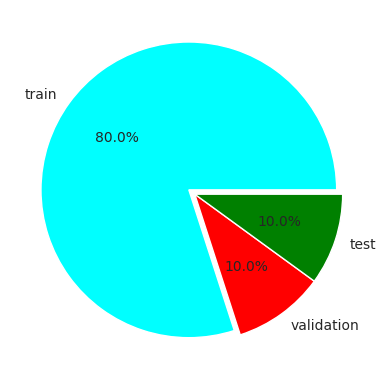

<Figure size 640x480 with 0 Axes>

In [6]:
# Plot dataset distribution
plt.pie([len(train_loader), len(valid_loader), len(test_loader)],  # Creating a pie chart
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))  # Setting labels, colors, and explode
plt.show()  # Displaying the pie chart
plt.savefig('dataset_pie.png')  # Saving the pie chart

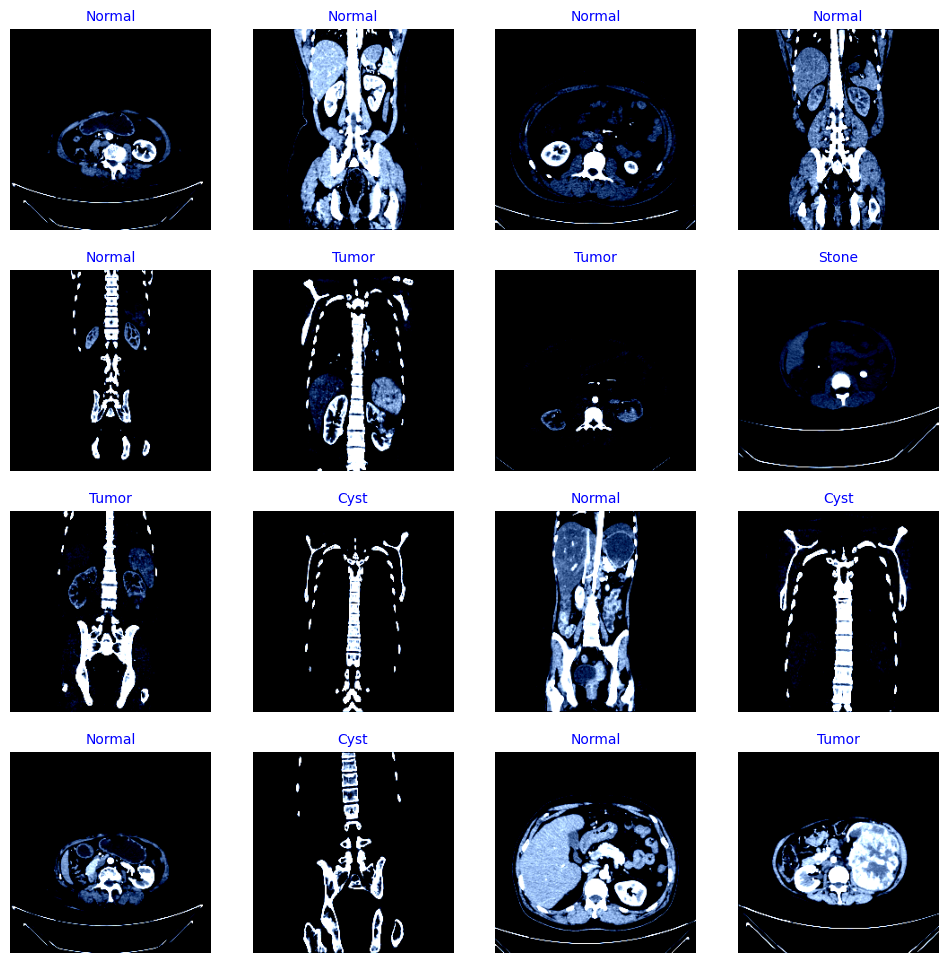

In [7]:
g_dict = class_indices  # Storing class indices
classes = list(g_dict.keys())  # Getting class names
images, labels = next(iter(train_loader))  # Getting a batch of images and labels

plt.figure(figsize=(12, 12))  # Setting the figure size

for i in range(16):  # Iterating through the first 16 images
    plt.subplot(4, 4, i + 1)  # Creating a subplot
    image = images[i].permute(1, 2, 0).numpy()  # Permuting and converting the image to numpy
    image = np.clip(image, 0, 1)  # Clipping the image values to [0, 1]
    plt.imshow(image)  # Displaying the image
    index = labels[i].item()  # Getting the label index
    class_name = classes[index]  # Getting the class name
    plt.title(class_name, color='blue', fontsize=10)  # Setting the title of the subplot
    plt.axis('off')  # Hiding the axis
plt.show()  # Displaying the figure

In [8]:
import torch.nn as nn  # Importing the neural network module from PyTorch again
import torchvision.models as models  # Importing models from torchvision again

# Define custom MobileNetV2 model
class MobileNetV2Model(nn.Module):  # Defining a custom MobileNetV2 model class
    def __init__(self, num_classes=4):  # Initializing the model
        super(MobileNetV2Model, self).__init__()  # Calling the superclass constructor
        self.base_model = models.mobilenet_v2(pretrained=True)  # Loading a pretrained MobileNetV2 model
        self.base_model.classifier[1] = nn.Sequential(  # Modifying the classifier layer
            nn.Linear(self.base_model.last_channel, 128),  # Adding a Linear layer
            nn.ReLU(),  # Adding a ReLU activation function
            nn.Dropout(0.5),  # Adding a Dropout layer
            nn.Linear(128, num_classes),  # Adding a Linear layer for the output
            nn.Softmax(dim=1)  # Adding a Softmax activation function
        )

    def forward(self, x):  # Defining the forward pass
        return self.base_model(x)  # Returning the output of the base model

num_classes = 4  # Setting the number of classes
mobilenetv2_model = MobileNetV2Model(num_classes=num_classes)  # Creating an instance of the MobileNetV2 model

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Setting the device to GPU if available, otherwise CPU
mobilenetv2_model.to(device)  # Moving the model to the device

MobileNetV2Model(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel

In [9]:
import torch  # Importing the PyTorch library again
import torch.optim as optim  # Importing the optimization module from PyTorch again
import torch.nn as nn  # Importing the neural network module from PyTorch again
import torch.nn.functional as F  # Importing functional module from PyTorch
from sklearn.metrics import f1_score  # Importing f1_score from sklearn
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting again

# Assuming mobilenetv2_model, train_loader, valid_loader, test_loader, and device are already defined

class FocalLoss(nn.Module):  # Defining a custom Focal Loss class
    def __init__(self, gamma=2, alpha=0.25):  # Initializing the Focal Loss
        super(FocalLoss, self).__init__()  # Calling the superclass constructor
        self.gamma = gamma  # Setting the gamma value
        self.alpha = alpha  # Setting the alpha value

    def forward(self, inputs, targets):  # Defining the forward pass
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')  # Calculating the cross-entropy loss
        pt = torch.exp(-BCE_loss)  # Calculating pt
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss  # Calculating the Focal Loss
        return F_loss.mean()  # Returning the mean loss

# Initialize the optimizer and loss function
optimizer = optim.Adam(mobilenetv2_model.parameters(), lr=0.001)  # Initializing the Adam optimizer
criterion = FocalLoss()  # Setting the loss function to Focal Loss

num_epochs = 3  # Setting the number of epochs

train_losses = []  # Initializing a list to store training losses
valid_losses = []  # Initializing a list to store validation losses
train_accuracies = []  # Initializing a list to store training accuracies
valid_accuracies = []  # Initializing a list to store validation accuracies

for epoch in range(num_epochs):  # Iterating through epochs
    mobilenetv2_model.train()  # Setting the model to training mode
    running_loss = 0.0  # Initializing the running loss
    correct = 0  # Initializing the correct predictions count
    total = 0  # Initializing the total samples count
    for images, labels in train_loader:  # Iterating through the training data loader
        images, labels = images.to(device), labels.to(device)  # Moving images and labels to the device
        optimizer.zero_grad()  # Zeroing the gradients
        outputs = mobilenetv2_model(images)  # Getting the model outputs
        loss = criterion(outputs, labels)  # Calculating the loss
        loss.backward()  # Backpropagating the loss
        optimizer.step()  # Updating the model parameters
        running_loss += loss.item()  # Accumulating the running loss
        _, predicted = torch.max(outputs, 1)  # Getting the predicted labels
        total += labels.size(0)  # Updating the total count
        correct += (predicted == labels).sum().item()  # Updating the correct count
    train_loss = running_loss / len(train_loader)  # Calculating the average training loss
    train_accuracy = correct / total  # Calculating the training accuracy
    train_losses.append(train_loss)  # Appending the training loss
    train_accuracies.append(train_accuracy)  # Appending the training accuracy

    mobilenetv2_model.eval()  # Setting the model to evaluation mode
    running_loss = 0.0  # Initializing the running loss for validation
    correct = 0  # Initializing the correct predictions count for validation
    total = 0  # Initializing the total samples count for validation
    with torch.no_grad():  # Disabling gradient calculation
        for images, labels in valid_loader:  # Iterating through the validation data loader
            images, labels = images.to(device), labels.to(device)  # Moving images and labels to the device
            outputs = mobilenetv2_model(images)  # Getting the model outputs
            loss = criterion(outputs, labels)  # Calculating the loss
            running_loss += loss.item()  # Accumulating the running loss
            _, predicted = torch.max(outputs, 1)  # Getting the predicted labels
            total += labels.size(0)  # Updating the total count
            correct += (predicted == labels).sum().item()  # Updating the correct count
    valid_loss = running_loss / len(valid_loader)  # Calculating the average validation loss
    valid_accuracy = correct / total  # Calculating the validation accuracy
    valid_losses.append(valid_loss)  # Appending the validation loss
    valid_accuracies.append(valid_accuracy)  # Appending the validation accuracy

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')  # Printing the epoch results
torch.save(mobilenetv2_model.state_dict(), 'mobilenetv2_model.pth')  # Saving the trained model

Epoch [1/3], Train Loss: 0.1016, Train Accuracy: 0.7871, Valid Loss: 0.0900, Valid Accuracy: 0.8345
Epoch [2/3], Train Loss: 0.0827, Train Accuracy: 0.8677, Valid Loss: 0.0722, Valid Accuracy: 0.9068
Epoch [3/3], Train Loss: 0.0787, Train Accuracy: 0.8846, Valid Loss: 0.0660, Valid Accuracy: 0.9365


In [10]:
# Evaluate the model on the test set
mobilenetv2_model.eval()  # Setting the model to evaluation mode
running_loss = 0.0  # Initializing the running loss for testing
correct = 0  # Initializing the correct predictions count for testing
total = 0  # Initializing the total samples count for testing
with torch.no_grad():  # Disabling gradient calculation
    for images, labels in test_loader:  # Iterating through the test data loader
        images, labels = images.to(device), labels.to(device)  # Moving images and labels to the device
        outputs = mobilenetv2_model(images)  # Getting the model outputs
        loss = criterion(outputs, labels)  # Calculating the loss
        running_loss += loss.item()  # Accumulating the running loss
        _, predicted = torch.max(outputs, 1)  # Getting the predicted labels
        total += labels.size(0)  # Updating the total count
        correct += (predicted == labels).sum().item()  # Updating the correct count
test_loss = running_loss / len(test_loader)  # Calculating the average test loss
test_accuracy = correct / total  # Calculating the test accuracy

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')  # Printing the test results

Test Loss: 0.0625, Test Accuracy: 0.9518


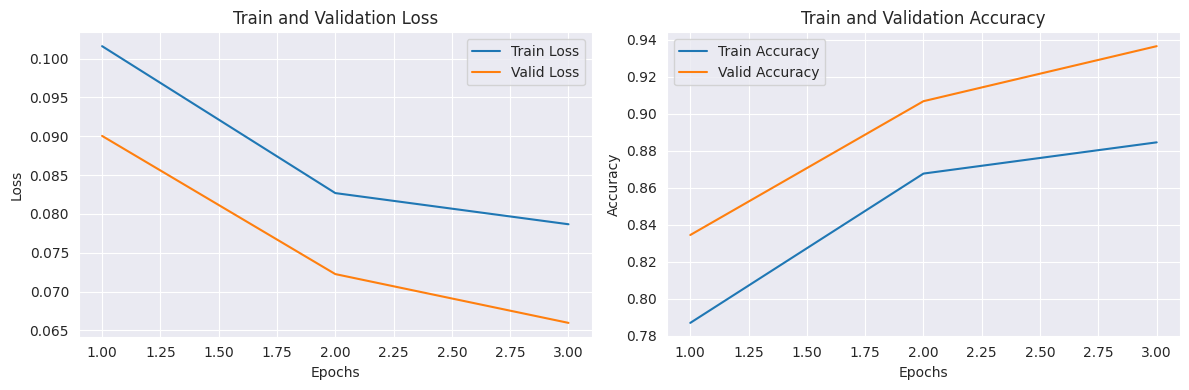

In [11]:
# Plotting
epochs = range(1, num_epochs + 1)  # Creating a range of epochs

plt.figure(figsize=(12, 4))  # Setting the figure size

plt.subplot(1, 2, 1)  # Creating a subplot
plt.plot(epochs, train_losses, label='Train Loss')  # Plotting training losses
plt.plot(epochs, valid_losses, label='Valid Loss')  # Plotting validation losses
plt.xlabel('Epochs')  # Setting the x-axis label
plt.ylabel('Loss')  # Setting the y-axis label
plt.title('Train and Validation Loss')  # Setting the plot title
plt.legend()  # Displaying the legend

plt.subplot(1, 2, 2)  # Creating another subplot
plt.plot(epochs, train_accuracies, label='Train Accuracy')  # Plotting training accuracies
plt.plot(epochs, valid_accuracies, label='Valid Accuracy')  # Plotting validation accuracies
plt.xlabel('Epochs')  # Setting the x-axis label
plt.ylabel('Accuracy')  # Setting the y-axis label
plt.title('Train and Validation Accuracy')  # Setting the plot title
plt.legend()  # Displaying the legend

plt.tight_layout()  # Adjusting the layout
plt.show()  # Displaying the figure


# Brevitas Export, FINN Import and Tidy-Up

In [12]:
from finn.util.basic import make_build_dir  # Importing the make_build_dir function, 
# Setting up build_dir points to the directory where build artifacts will be stored.
from finn.util.visualization import showInNetron  # Importing the showInNetron function
import os  # Importing the os module

build_dir = os.environ["FINN_BUILD_DIR"]  # Setting the build directory from environment variable

These steps involve creating a clean and organized build directory, cleaning up the initial ONNX model, and then applying a series of transformations to optimize the model for FPGA deployment. Each transformation plays a specific role in making the model more efficient and easier to work with, ultimately resulting in a version of the model that is well-suited for hardware implementation.

In [13]:
import torch  # Importing PyTorch
import onnx  # Importing ONNX
from finn.util.basic import make_build_dir  # Importing the make_build_dir function again
from finn.util.visualization import showInNetron  # Importing the showInNetron function again
from qonnx.util.cleanup import cleanup as qonnx_cleanup  # Importing the cleanup function and renaming it
from qonnx.core.modelwrapper import ModelWrapper  # Importing ModelWrapper class
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN  # Importing conversion function
from qonnx.transformation.infer_shapes import InferShapes  # Importing shape inference transformation
from qonnx.transformation.fold_constants import FoldConstants  # Importing constant folding transformation
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs  # Importing general transformations

# Define custom MobileNetV2 model
class MobileNetV2Model(nn.Module):  # Defining a custom MobileNetV2 model class
    def __init__(self, num_classes=4):  # Initializing the model
        super(MobileNetV2Model, self).__init__()  # Calling the parent constructor
        self.base_model = models.mobilenet_v2(pretrained=True)  # Loading pretrained MobileNetV2
        self.base_model.classifier[1] = nn.Sequential(  # Modifying the classifier
            nn.Linear(self.base_model.last_channel, 128),  # Adding a Linear layer
            nn.ReLU(),  # Adding a ReLU activation
            nn.Dropout(0.5),  # Adding a Dropout layer
            nn.Linear(128, num_classes),  # Adding another Linear layer
            nn.Softmax(dim=1)  # Adding a Softmax activation
        )

    def forward(self, x):  # Defining the forward pass
        return self.base_model(x)  # Forwarding the input through the base model

num_classes = 4  # Setting the number of output classes
mobilenetv2_model = MobileNetV2Model(num_classes=num_classes)  # Creating the MobileNetV2 model

# Load the trained model weights
mobilenetv2_model.load_state_dict(torch.load('mobilenetv2_model.pth'))  # Loading the trained weights

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Setting the device to GPU if available, else CPU
mobilenetv2_model.to(device)  # Moving the model to the device

# Export the model to ONNX
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Creating a dummy input tensor
export_onnx_path = "mobilenetv2_model_export.onnx"  # Setting the export path
torch.onnx.export(mobilenetv2_model, dummy_input, export_onnx_path, input_names=['input'], output_names=['output'])  # Exporting the model to ONNX

# Apply FINN and QONNX transformations
build_dir = make_build_dir("mobilenetv2_model")  # Creating a build directory
#This line creates a new directory specifically for storing the build artifacts related to the MobileNetV2 model.
qonnx_cleanup(export_onnx_path, out_file=export_onnx_path)  # Cleaning up the ONNX model
model = ModelWrapper(export_onnx_path)  # Wrapping the ONNX model
model = model.transform(ConvertQONNXtoFINN())  # Converting QONNX to FINN
model = model.transform(InferShapes())  # Inferring shapes
model = model.transform(FoldConstants())  # Folding constants
model = model.transform(GiveUniqueNodeNames())  # Giving unique node names
model = model.transform(GiveReadableTensorNames())  # Giving readable tensor names
model = model.transform(RemoveStaticGraphInputs())  # Removing static graph inputs
model.save(build_dir + "/mobilenetv2_model_tidy.onnx")  # Saving the transformed model

- build_dir = make_build_dir("mobilenetv2_model")
What it does: This line creates a new directory specifically for storing the build artifacts related to the MobileNetV2 model.
Why? Organizing the output files in a dedicated directory helps keep the workspace clean and makes it easier to manage and locate files related to this particular model.
- qonnx_cleanup(export_onnx_path, out_file=export_onnx_path)
What it does: This function cleans up the exported ONNX model by removing unnecessary elements and making it more efficient.
Why? Cleaning up the model ensures that any redundant or unused components are removed, which can help improve performance and make subsequent transformations more effective.
- model = ModelWrapper(export_onnx_path)
What it does: This wraps the ONNX model file in a ModelWrapper object, which provides methods and attributes to manipulate the model.
Why? Wrapping the model makes it easier to apply various transformations and optimizations using the provided methods.
- model = model.transform(InferShapes())
What it does: This transformation infers the shapes of all tensors in the model.
Why? Knowing the shapes of tensors is crucial for optimizing the model and ensuring that subsequent transformations can be applied correctly.
- model = model.transform(FoldConstants())
What it does: This transformation folds constant values into the model, effectively replacing operations that involve constants with their results.
Why? Folding constants simplifies the model and can improve runtime performance by reducing the number of operations that need to be performed during inference.
- model = model.transform(GiveUniqueNodeNames())
What it does: This transformation ensures that each node in the model has a unique name.
Why? Unique node names prevent conflicts and ambiguities, making it easier to track and debug the model.
- model = model.transform(GiveReadableTensorNames())
What it does: This transformation assigns human-readable names to the tensors in the model.
Why? Readable names make the model easier to understand and work with, especially during debugging and visualization.
- model = model.transform(RemoveStaticGraphInputs())
What it does: This transformation removes any static (constant) inputs from the graph.
Why? Removing static inputs simplifies the model and can reduce memory usage, making the model more efficient.
- model.save(build_dir + "/mobilenetv2_model_tidy.onnx")
What it does: This saves the transformed and optimized model to a new ONNX file in the build directory.
Why? Saving the model at this stage preserves the transformations and optimizations applied so far, creating a clean and efficient version of the model that can be used for further processing or deployment.

In [14]:
# Show the model in Netron
showInNetron(build_dir + "/mobilenetv2_model_tidy.onnx")  # Displaying the model in Netron

Serving '/tmp/finn_dev_emanuel/mobilenetv2_modelzjsoun24/mobilenetv2_model_tidy.onnx' at http://0.0.0.0:8081


# Adding Pre- and Postprocessing

In [15]:
from finn.util.pytorch import ToTensor  # Importing the ToTensor function
from qonnx.transformation.merge_onnx_models import MergeONNXModels  # Importing model merging transformation
from qonnx.core.datatype import DataType  # Importing DataType class

# Define the export_qonnx function
def export_qonnx(model, input_tensor, export_path):  # Defining the export function
    model.eval()  # Setting the model to evaluation mode
    torch.onnx.export(model, input_tensor, export_path, export_params=True, opset_version=12,
                      do_constant_folding=True, input_names=['input'], output_names=['output'])  # Exporting the model to ONNX
#What it does: This function exports a given PyTorch model to the ONNX format.
#Why? Exporting the model to ONNX allows for subsequent transformations and optimizations using 
#ONNX-specific tools and frameworks.

model = ModelWrapper(build_dir+"/mobilenetv2_model_tidy.onnx")  # Wrapping the tidy model
global_inp_name = model.graph.input[0].name  # Getting the global input name
ishape = model.get_tensor_shape(global_inp_name)  # Getting the input shape
# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()  # Creating the ToTensor preprocessing object
chkpt_preproc_name = build_dir+"/mobilenetv2_model_tidy_preproc.onnx"  # Setting the preprocessing checkpoint name
export_qonnx(totensor_pyt, torch.randn(ishape), chkpt_preproc_name)  # Exporting the preprocessing step
#What it does: This creates a ToTensor preprocessing object, sets the checkpoint name for the preprocessing step, 
#and exports this preprocessing step to an ONNX file.
#Why? Preprocessing the input data (e.g., normalizing pixel values) is essential to match the model's expected input format,
#improving model performance and accuracy.
qonnx_cleanup(chkpt_preproc_name, out_file=chkpt_preproc_name)  # Cleaning up the preprocessing ONNX model
#Cleaning up ensures the preprocessing model is optimized and free of unnecessary elements, improving efficiency.
pre_model = ModelWrapper(chkpt_preproc_name)  # Wrapping the preprocessing model
pre_model = pre_model.transform(ConvertQONNXtoFINN())  # Converting QONNX to FINN for preprocessing

# join preprocessing and core model
model = model.transform(MergeONNXModels(pre_model))  # Merging preprocessing and core models
#What it does: This merges the preprocessing model with the core model, 
#creating a single ONNX model that includes both preprocessing and inference steps.
#Why? Merging the models simplifies deployment by having a single model file that handles both
#input preprocessing and inference, ensuring consistency and reducing complexity.
# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name  # Getting the global input name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])  # Setting the input tensor datatype to UINT8
#Setting the correct data type for the input tensor is crucial for ensuring that the model processes the input data correctly,
#especially when deploying to hardware like FPGAs, which often require specific data types for optimal performance.

-global_inp_name = model.graph.input[0].name  # Getting the global input name
-ishape = model.get_tensor_shape(global_inp_name)  # Getting the input shape
What it does: These lines retrieve the name and shape of the global input tensor of the model.
Why? Knowing the input tensor's name and shape is crucial for preprocessing the input data and ensuring compatibility with the model's requirements.


In [16]:
from qonnx.transformation.insert_topk import InsertTopK  # Importing Top-K insertion transformation
from qonnx.transformation.infer_datatypes import InferDataTypes  # Importing datatype inference transformation

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))  # Inserting Top-1 node
chkpt_name = build_dir+"/mobilenetv2_model_tidy_pre_post.onnx"  # Setting the checkpoint name
# tidy-up again
model = model.transform(InferShapes())  # Inferring shapes again
model = model.transform(FoldConstants())  # Folding constants again
model = model.transform(GiveUniqueNodeNames())  # Giving unique node names again
model = model.transform(GiveReadableTensorNames())  # Giving readable tensor names again
model = model.transform(InferDataTypes())  # Inferring datatypes
model = model.transform(RemoveStaticGraphInputs())  # Removing static graph inputs again
model.save(chkpt_name)  # Saving the transformed model
#Saving the model at this stage ensures that all transformations are preserved,
#making it ready for further processing, deployment, or evaluation.

-model = model.transform(InsertTopK(k=1))  # Inserting Top-1 node
-chkpt_name = build_dir+"/mobilenetv2_model_tidy_pre_post.onnx"  # Setting the checkpoint name
What it does: This inserts a Top-1 node into the model, which ranks the outputs and keeps only the highest-scoring class. The checkpoint name for this modified model is also set.
Why? Inserting a Top-1 node is crucial for classification tasks where you need to identify the highest scoring class out of many possible classes. Setting a checkpoint name helps in saving the intermediate state of the model.
-Infer Shapes: Re-infers the shapes of all tensors in the model to ensure correctness.
-Fold Constants: Identifies and folds constant nodes to simplify the model.
-Give Unique Node Names: Ensures all nodes have unique names to avoid conflicts.
-Give Readable Tensor Names: Provides readable names for tensors to improve clarity.
-Infer Data Types: Infers the data types of tensors to ensure they are correct.
-Remove Static Graph Inputs: Removes any static (unused) inputs from the graph to clean it up.
Why?
-Infer Shapes: Ensures all tensor shapes are correct and consistent throughout the model.
-Fold Constants: Simplifies the model by merging constant operations.
-Give Unique Node Names: Prevents naming conflicts that could cause errors during deployment.
-Give Readable Tensor Names: Improves model readability and ease of debugging.
-Infer Data Types: Ensures all tensors have the correct data types for operations.
-Remove Static Graph Inputs: Cleans up the model by removing unnecessary inputs.

In [17]:
showInNetron(build_dir+"/mobilenetv2_model_tidy_pre_post.onnx")  # Displaying the model in Netron

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emanuel/mobilenetv2_modelzjsoun24/mobilenetv2_model_tidy_pre_post.onnx' at http://0.0.0.0:8081


In [18]:
from finn.transformation.streamline import Streamline  # Importing Streamline transformation
from qonnx.transformation.lower_convs_to_matmul import LowerConvsToMatMul  # Importing convolution lowering transformation
from qonnx.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount  # Importing bipolar conversion transformation
import finn.transformation.streamline.absorb as absorb  # Importing absorb transformations
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants  # Importing reorder transformations
from qonnx.transformation.infer_data_layouts import InferDataLayouts  # Importing data layout inference transformation
from qonnx.transformation.general import RemoveUnusedTensors  # Importing unused tensor removal transformation

# These transformations help to simplify the model by converting operations, 
# absorbing unnecessary nodes, and removing unused tensors, making the model more efficient for deployment on hardware.

model = ModelWrapper(build_dir + "/mobilenetv2_model_tidy_pre_post.onnx")  # Wrapping the tidy pre-post model
#Wrapping the model allows the application of various transformation functions in a structured manner.
model = model.transform(MoveScalarLinearPastInvariants())  # Moving scalar linear past invariants
#Moving scalar operations can simplify the computation graph and improve performance.
model = model.transform(Streamline())  # Streamlining the model
#Streamlining simplifies the model by removing redundant operations and optimizing the computation graph.
model = model.transform(LowerConvsToMatMul())  # Lowering convolutions to matrix multiplications
model = model.transform(MakeMaxPoolNHWC())  # Making MaxPool NHWC
#Converts the MaxPool operations to use the NHWC (batch, height, width, channels) data layout.
#Why? NHWC is often more efficient for hardware processing and can improve performance.
model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())  # Absorbing transposes into multi-threshold
# Absorbing transposes simplifies the model by removing unnecessary transpose operations.
model = model.transform(ConvertBipolarMatMulToXnorPopcount())  # Converting bipolar matmul to xnor popcount
#XNOR-popcount is more efficient for binary neural networks and can significantly speed up inference.
model = model.transform(Streamline())  # Streamlining again
#Further streamlining removes any new redundancies introduced by previous transformations.
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())  # Absorbing scalar mul-add into TopK
#Simplifying the final layers of the model can reduce computation and improve performance.
model = model.transform(InferDataLayouts())  # Inferring data layouts
#Ensuring correct data layouts is crucial for efficient hardware execution.
model = model.transform(RemoveUnusedTensors())  # Removing unused tensors
#Cleaning up unused tensors reduces memory usage and simplifies the model.
model.save(build_dir + "/mobilenetv2_model_streamlined.onnx")  # Saving the streamlined model

In [19]:
showInNetron(build_dir+"/mobilenetv2_model_streamlined.onnx")  # Displaying the streamlined model in Netron

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emanuel/mobilenetv2_modelzjsoun24/mobilenetv2_model_streamlined.onnx' at http://0.0.0.0:8081


# Partitioning, Conversion to HW Layers and Folding

In [20]:
from finn.util.basic import pynq_part_map  # Importing the PYNQ part map
#Imports a dictionary that maps PYNQ board names to their corresponding FPGA parts.
# change this if you have a different PYNQ board, see list above
pynq_board = "Pynq-Z1"  # Setting the PYNQ board
fpga_part = pynq_part_map[pynq_board]  # Getting the FPGA part for the board
target_clk_ns = 10  # Setting the target clock period
#These settings are used to configure the FPGA hardware for the specific PYNQ board, 
#ensuring that the generated hardware matches the board's capabilities and constraints.
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw  # Importing hardware layer conversion transformations
from finn.transformation.fpgadataflow.create_dataflow_partition import CreateDataflowPartition  # Importing dataflow partition creation transformation
from finn.transformation.move_reshape import RemoveCNVtoFCFlatten  # Importing flatten removal transformation
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers  # Importing layer specialization transformation
from qonnx.custom_op.registry import getCustomOp  # Importing custom operation registry

model = ModelWrapper(build_dir + "/mobilenetv2_model_streamlined.onnx")  # Wrapping the streamlined model
# Wrapping the model allows the application of hardware-specific transformation functions in a structured manner.
model = model.transform(to_hw.InferBinaryMatrixVectorActivation())  # Inferring binary matrix-vector activation
model = model.transform(to_hw.InferQuantizedMatrixVectorActivation())  # Inferring quantized matrix-vector activation
#Infers and converts matrix-vector activation layers for binary and quantized data.
# TopK to LabelSelect
model = model.transform(to_hw.InferLabelSelectLayer())  # Inferring label select layer
# input quantization (if any) to standalone thresholding
model = model.transform(to_hw.InferThresholdingLayer())  # Inferring thresholding layer
model = model.transform(to_hw.InferConvInpGen())  # Inferring convolution input generator
model = model.transform(to_hw.InferStreamingMaxPool())  # Inferring streaming MaxPool
#These transformations prepare these specific layers for efficient execution on FPGA.

# get rid of Reshape(-1, 1) operation between hw nodes
model = model.transform(RemoveCNVtoFCFlatten())  # Removing CNV to FC flatten
# get rid of Tranpose -> Tranpose identity seq
model = model.transform(absorb.AbsorbConsecutiveTransposes())  # Absorbing consecutive transposes
# infer tensor data layouts
model = model.transform(InferDataLayouts())  # Inferring data layouts
parent_model = model.transform(CreateDataflowPartition())  # Creating dataflow partition
parent_model.save(build_dir + "/mobilenetv2_model_dataflow_parent.onnx")  # Saving the dataflow parent model
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]  # Getting the first streaming dataflow partition node
sdp_node = getCustomOp(sdp_node)  # Getting the custom operation for the node
dataflow_model_filename = sdp_node.get_nodeattr("model")  # Getting the model attribute
# save the dataflow partition with a different name for easier access
# and specialize the layers to HLS variants
dataflow_model = ModelWrapper(dataflow_model_filename)  # Wrapping the dataflow model
dataflow_model = dataflow_model.transform(SpecializeLayers(fpga_part))  # Specializing layers to HLS variants
dataflow_model.save(build_dir + "/mobilenetv2_model_dataflow_model.onnx")  # Saving the dataflow model

-RemoveCNVtoFCFlatten: Removes unnecessary flatten operations between convolutional and fully connected layers.
-AbsorbConsecutiveTransposes: Absorbs consecutive transpose operations into a single operation.

In [21]:
showInNetron(build_dir + "/mobilenetv2_model_dataflow_parent.onnx")  # Displaying the dataflow parent model in Netron

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emanuel/mobilenetv2_modelzjsoun24/mobilenetv2_model_dataflow_parent.onnx' at http://0.0.0.0:8081


In [22]:
showInNetron(build_dir + "/mobilenetv2_model_dataflow_model.onnx")  # Displaying the dataflow model in Netron

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emanuel/mobilenetv2_modelzjsoun24/mobilenetv2_model_dataflow_model.onnx' at http://0.0.0.0:8081


In [23]:
# Load the transformed model for folding configuration
# This loads the ONNX model that has been tidied up by previous transformations
model = ModelWrapper(build_dir + "/mobilenetv2_model_dataflow_model.onnx")  # Wrapping the dataflow model

# Get the MVAU layers (Matrix-Vector Activation Unit)
# This retrieves all nodes in the model that use the "MVAU_hls" operation type
fc_layers = model.get_nodes_by_op_type("MVAU_hls")  # Getting the MVAU layers
#These layers will be configured with specific folding parameters to optimize their performance on FPGA.

# Define the folding configuration for each layer
# Each tuple represents the configuration for a layer in the format (PE, SIMD, in_fifo_depth)
folding = [
    (16, 3, [128]),   # Layer 1: PE = 16, SIMD = 3, in_fifo_depth = [128]
    (32, 32, [128]),  # Layer 2: PE = 32, SIMD = 32, in_fifo_depth = [128]
    (16, 32, [128]),  # Layer 3: PE = 16, SIMD = 32, in_fifo_depth = [128]
    (16, 32, [128]),  # Layer 4: PE = 16, SIMD = 32, in_fifo_depth = [128]
    (4, 32, [81]),    # Layer 5: PE = 4, SIMD = 32, in_fifo_depth = [81]
    (1, 32, [2]),     # Layer 6: PE = 1, SIMD = 32, in_fifo_depth = [2]
    (1, 4, [2]),      # Layer 7: PE = 1, SIMD = 4, in_fifo_depth = [2]
    (1, 8, [128]),    # Layer 8: PE = 1, SIMD = 8, in_fifo_depth = [128]
    (5, 1, [3]),      # Layer 9: PE = 5, SIMD = 1, in_fifo_depth = [3]
]

# Apply the folding configuration to the MVAU layers
# This loop iterates over each MVAU layer and applies the corresponding folding parameters
for fcl, (pe, simd, ififodepth) in zip(fc_layers, folding):  # Iterating over MVAU layers and folding configuration
    fcl_inst = getCustomOp(fcl)  # Getting the custom operation instance for the layer
    fcl_inst.set_nodeattr("PE", pe)  # Setting the PE (Processing Elements) attribute
    fcl_inst.set_nodeattr("SIMD", simd)  # Setting the SIMD (Single Instruction Multiple Data) attribute
    fcl_inst.set_nodeattr("inFIFODepths", ififodepth)  # Setting the input FIFO depths attribute

# Get the ConvolutionInputGenerator layers
# This retrieves all nodes in the model that use the "ConvolutionInputGenerator_rtl" operation type
swg_layers = model.get_nodes_by_op_type("ConvolutionInputGenerator_rtl")  # Getting the convolution input generator layers
#These layers need to be configured with the same SIMD values as the 
#corresponding MVAU layers to ensure consistency in data processing.

# Apply the same SIMD values to the sliding window operators
# This loop iterates over each sliding window generator layer and sets the SIMD attribute
for i in range(len(swg_layers)):  # Iterating over sliding window generator layers
    swg_inst = getCustomOp(swg_layers[i])  # Getting the custom operation instance for the layer
    simd = folding[i][1]  # Getting the SIMD value from the folding configuration
    swg_inst.set_nodeattr("SIMD", simd)  # Setting the SIMD attribute

# Ensure the model has unique node names and save it
# This transformation ensures that all nodes in the model have unique names
model = model.transform(GiveUniqueNodeNames())  # Giving unique node names
# Save the modified model to a new ONNX file
model.save(build_dir + "/mobilenetv2_model_folded.onnx")  # Saving the folded model

In [24]:
# Show the model in Netron
# This function opens the saved ONNX model in the Netron visualizer
showInNetron(build_dir + "/mobilenetv2_model_folded.onnx")  # Displaying the folded model in Netron

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emanuel/mobilenetv2_modelzjsoun24/mobilenetv2_model_folded.onnx' at http://0.0.0.0:8081


# Hardware Generation

In [25]:
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild  # Importing Zynq build transformation
#This transformation is necessary to prepare the model for deployment on a Zynq FPGA, which 
#involves creating a hardware project suitable for the specified platform.
model = ModelWrapper(build_dir+"/mobilenetv2_model_folded.onnx")  # Wrapping the folded model
#This step prepares the folded model for the next transformation, which will convert it into 
#a format suitable for deployment on a Zynq FPGA.
model = model.transform(ZynqBuild(platform = pynq_board, period_ns = target_clk_ns))  # Building the model for Zynq

-Importing Zynq Build Transformation: To prepare for building the model for Zynq FPGA.
-Wrapping the Folded Model: Loads and prepares the folded model for further transformation.
-Building the Model for Zynq Platform: Configures and builds the model for deployment on the specified Zynq FPGA platform, optimizing it for the given target clock period.

After the ZynqBuild we run one additional transformation to generate a PYNQ driver for the accelerator.

In [26]:
from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver  # Importing PYNQ driver transformation
#This transformation is necessary to generate the Python driver that will run the model on the PYNQ platform, facilitating
#communication between the FPGA and the host processor.
model = model.transform(MakePYNQDriver("zynq-iodma"))  # Creating the PYNQ driver specifying "zynq-iodma" as the type of interface.

In [27]:
model.save(build_dir + "/mobilenetv2_model_.onnx")  # Saving the model with PYNQ driver
#Saves the updated model to a new ONNX file.

# Deployment and Execution

In [28]:
from shutil import copy  # Importing copy function
from distutils.dir_util import copy_tree  # Importing copy_tree function

#These functions are necessary for preparing the deployment package by copying all required files
#and directories to a specified deployment directory.

# create directory for deployment files
deployment_dir = make_build_dir(prefix="pynq_deployment_")  # Creating a directory for deployment files
model.set_metadata_prop("pynq_deployment_dir", deployment_dir)  # Setting the deployment directory metadata

#This step organizes the deployment files in a dedicated directory, making it easier to manage and 
#transfer the necessary files for deploying the model on the PYNQ platform.

# get and copy necessary files
# .bit and .hwh file
bitfile = model.get_metadata_prop("bitfile")  # Getting the bitfile
hwh_file = model.get_metadata_prop("hw_handoff")  # Getting the hardware handoff file
deploy_files = [bitfile, hwh_file]  # List of files to be deployed

for dfile in deploy_files:  # Iterating over the deployment files
    if dfile is not None:  # Checking if the file is not None
        copy(dfile, deployment_dir)  # Copying the file to the deployment directory

#Retrieves the paths to the bitfile and hardware handoff file from the model's metadata.
#Copies these files to the deployment directory.

# driver.py and python libraries
pynq_driver_dir = model.get_metadata_prop("pynq_driver_dir")  # Getting the PYNQ driver directory
copy_tree(pynq_driver_dir, deployment_dir)  # Copying the PYNQ driver directory to the deployment directory
# The PYNQ driver directory contains the necessary Python code and libraries for running the model on the PYNQ platform. 
#Copying this directory ensures that all required software components are included in the deployment package.

['/tmp/finn_dev_emanuel/pynq_deployment_b5rb_8ij/driver_base.py',
 '/tmp/finn_dev_emanuel/pynq_deployment_b5rb_8ij/finn/util/data_packing.py',
 '/tmp/finn_dev_emanuel/pynq_deployment_b5rb_8ij/finn/util/__init__.py',
 '/tmp/finn_dev_emanuel/pynq_deployment_b5rb_8ij/validate.py',
 '/tmp/finn_dev_emanuel/pynq_deployment_b5rb_8ij/driver.py',
 '/tmp/finn_dev_emanuel/pynq_deployment_b5rb_8ij/qonnx/util/basic.py',
 '/tmp/finn_dev_emanuel/pynq_deployment_b5rb_8ij/qonnx/util/__init__.py',
 '/tmp/finn_dev_emanuel/pynq_deployment_b5rb_8ij/qonnx/core/__init__.py',
 '/tmp/finn_dev_emanuel/pynq_deployment_b5rb_8ij/qonnx/core/datatype.py']

-Importing PYNQ Driver Transformation: To generate the driver for the model.
-Creating and Saving the PYNQ Driver: Generates the driver and saves the updated model.
-Importing File Operations Functions: To copy necessary files and directories.
-Creating Deployment Directory: Organizes the deployment files.
-Copying Necessary Files: Ensures all required hardware and software components are included in the deployment package.

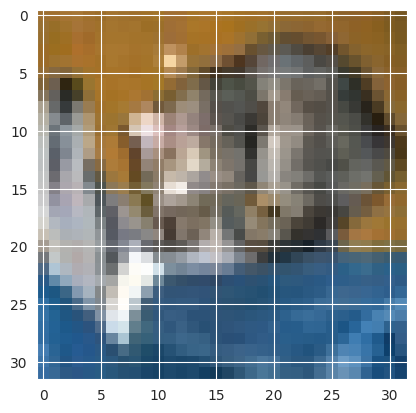

In [29]:
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np

ref = importlib_resources.files("finn.qnn-data") / "cifar10/cifar10-test-data-class3.npz"
with importlib_resources.as_file(ref) as fn:
    x = np.load(fn)["arr_0"]
x = x.reshape(3, 32,32).transpose(1, 2, 0)
plt.imshow(x)

In [30]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob

# Define the path to your kidney stone dataset directory
dataset_dir = "/home/vitis/finn/notebooks/kaggle/input/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"   # Update this path

# Function to load and preprocess the kidney stone dataset
def load_kidney_stone_dataset(dataset_dir, target_shape):
    images = []
    for filepath in glob.glob(os.path.join(dataset_dir, '*.jpg')):  # Adjust the extension if necessary
        img = Image.open(filepath)
        img = img.resize(target_shape)
        img = np.array(img)
        images.append(img)
    images = np.stack(images)
    return images

# Target shape (height, width) for resizing the images
target_shape = (32, 32)  # Adjust based on your requirement

# Load the dataset
kidney_stone_images = load_kidney_stone_dataset(dataset_dir, target_shape)

# Display an example image
x = kidney_stone_images[0]
#x = x.reshape(3, 32, 32).transpose(1, 2, 0)  # Adjust the shape if necessary
plt.imshow(x)
plt.show()

# Save an example image for deployment
np.save(deployment_dir + "/input.npy", x)


ValueError: need at least one array to stack

In [ ]:
! ls {deployment_dir}

In [ ]:
from shutil import make_archive
make_archive('deploy-on-pynq-cnv', 'zip', deployment_dir)